# Set Up

## Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from time import time
from CBFV import composition
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler, normalize, OrdinalEncoder
from sklearn.model_selection import learning_curve, RandomizedSearchCV, cross_validate, GroupKFold, KFold
import shap
import random
from dtreeviz import trees
from dtreeviz.models.xgb_decision_tree import ShadowXGBDTree

/Users/andrew/Desktop/School/Research/ChemML/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Seed and Paths

In [2]:
RNG_SEED = 8
np.random.seed(RNG_SEED)
curr_dir = os.getcwd()
DATA_PATH = os.path.join(os.path.dirname(curr_dir), 'Data')
MODELS_PATH = os.path.join(os.path.dirname(curr_dir), 'Models')
WEIGHTS_PATH = os.path.join(os.path.dirname(curr_dir), 'Weights')
ASSETS_PATH = os.path.join(os.path.dirname(curr_dir), 'Assets')
RESULTS_PATH = os.path.join(os.path.dirname(curr_dir), 'Results')

# Data

## Collection

In [3]:
df_train = pd.read_csv(DATA_PATH + "/intermetallics_train7.csv")
df_val = pd.read_csv(DATA_PATH + "/intermetallics_val7.csv")
df_test = pd.read_csv(DATA_PATH + "/intermetallics_test7.csv")

## Preprocessing

In [4]:
# remove categorical data and individual atomic fractions added with matminer (except B)
df_train.drop(columns=['composition', 'material_id',
              'structure'], axis=1, inplace=True)

df_val.drop(columns=['composition', 'material_id',
            'structure'], axis=1, inplace=True)

df_test.drop(columns=['composition', 'material_id',
             'structure'], axis=1, inplace=True)

# Gonna train  total_magnetization_ per formula unit so need to remove all other magnetic fields as to not overtrain the data
df_train.drop(['total_magnetization',
              'total_magnetization_normalized_vol'], axis=1, inplace=True)
df_val.drop(['total_magnetization',
            'total_magnetization_normalized_vol'], axis=1, inplace=True)
df_test.drop(['total_magnetization',
             'total_magnetization_normalized_vol'], axis=1, inplace=True)

# save an example of the final training dataFrame, so that I can match the order of columns
df_train.to_csv(os.path.join(
    DATA_PATH, 'trainSet_columnOrder.csv'), index=False)

print(f'df_train DataFrame shape: {df_train.shape}')
print(f'df_val DataFrame shape: {df_val.shape}')
print(f'df_test DataFrame shape: {df_test.shape}')

df_train DataFrame shape: (5872, 1594)
df_val DataFrame shape: (1722, 1594)
df_test DataFrame shape: (844, 1594)


In [5]:
# Need to rename formula_pretty column to formula and total_magnetization_formula_units to target since CBFV needs that
rename_dict = {'total_magnetization_normalized_formula_units': 'target'}
df_train = df_train.rename(columns=rename_dict)
df_val = df_val.rename(columns=rename_dict)
df_test = df_test.rename(columns=rename_dict)

X_train_unscaled, y_train, formulae_train, skipped_train = composition.generate_features(
    df_train, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)
X_val_unscaled, y_val, formulae_val, skipped_val = composition.generate_features(
    df_val, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_unscaled, y_test, formulae_test, skipped_test = composition.generate_features(
    df_test, elem_prop='magpie', drop_duplicates=False, extend_features=True, sum_feat=True)

columns = X_train_unscaled.columns.values.tolist()

Processing Input Data: 100%|██████████| 5872/5872 [00:00<00:00, 38228.40it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 5872/5872 [00:00<00:00, 37508.06it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 1722/1722 [00:00<00:00, 55979.53it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 1722/1722 [00:00<00:00, 36971.24it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 844/844 [00:00<00:00, 55087.73it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 844/844 [00:00<00:00, 36321.03it/s]


	Creating Pandas Objects...


In [6]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_unscaled)
X_val = scaler.transform(X_val_unscaled)
X_test = scaler.transform(X_test_unscaled)

# X_train = normalize(X_train)
# X_val = normalize(X_val)
# X_test = normalize(X_test)

In [7]:
# Concatenate the train and validation datasets together
X_train_new = np.concatenate((X_train, X_val), axis=0)
y_train_new = pd.concat((y_train, y_val), axis=0)

print(X_train_new.shape)

(7594, 1746)


In [8]:
# Using K-fold Cross validation to check for overfitting and get a better idea of the errors

# formula group needs to be integers
enc = OrdinalEncoder()

df_train_new = pd.concat((df_train, df_val), axis=0)
enc.fit(df_train_new[["formula", "number"]])
df_train_new[["formula", "number"]] = enc.transform(
    df_train_new[["formula", "number"]])

groups = df_train_new['formula']
gkf = GroupKFold(n_splits = 5)
# gkf = KFold(n_splits=5, random_state=42, shuffle=True)

## Data Analysis

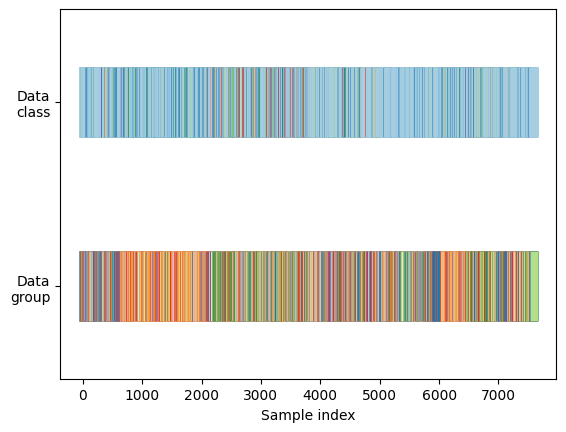

In [9]:
# Visualize data for CV
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm


def visualize_groups(classes, groups, name):
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )
    return fig


data_vis = visualize_groups(y_train_new, groups, "no groups")

In [10]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=5):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

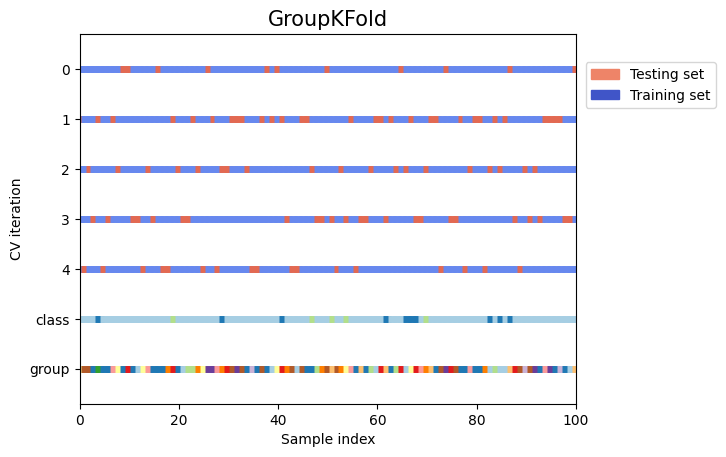

In [11]:
# Plotting CV

fig, ax = plt.subplots()
cv = GroupKFold(n_splits=5)
cv_plot = plot_cv_indices(gkf, df_train_new, y_train_new, groups, ax, 5)

ax.legend(
    [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
    ["Testing set", "Training set"],
    loc=(1.02, 0.8),
)

# Models

## Basic

### Training

In [12]:
xgb.set_config(verbosity=1)

xgb_cv_model = XGBRegressor(learning_rate=0.05, max_depth=8,
                            subsample=0.8, colsample_bytree=0.5, min_child_weight=3, n_estimators=300)

scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}

ti = time()

scores = cross_validate(xgb_cv_model, X_train_new, y_train_new, groups=groups,
                        verbose=0, scoring=scoring, cv=gkf, return_train_score=True, error_score='raise')

xgb_cv_model.fit(X_train_new, y_train_new, verbose=True)

dt = time() - ti

print(f'Finished fitting model, total time: {dt:0.2f} s')

print(scores.keys())

Finished fitting model, total time: 139.15 s
dict_keys(['fit_time', 'score_time', 'test_r2', 'train_r2', 'test_rmse', 'train_rmse'])


### Evaluation

In [13]:
# Print cross-validation scores
print("Cross-validation R-squared scores:", scores['test_r2'])
print("Mean R-squared score:", scores['test_r2'].mean())

print("Cross-validation RMSE scores:", -scores['test_rmse'])
print("Mean RMSE score:", -scores['test_rmse'].mean())

Cross-validation R-squared scores: [0.91213967 0.92692344 0.8550689  0.90127499 0.90810605]
Mean R-squared score: 0.9007026090246519
Cross-validation RMSE scores: [2.77522019 2.29616608 3.81113357 3.00640826 2.84718325]
Mean RMSE score: 2.9472222679300417


In [14]:
y_pred = xgb_cv_model.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.4f}")

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error: {rmse:.4f}")

R-squared: 0.8844
Root Mean Squared Error: 3.1022


/Users/andrew/Desktop/School/Research/ChemML/env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


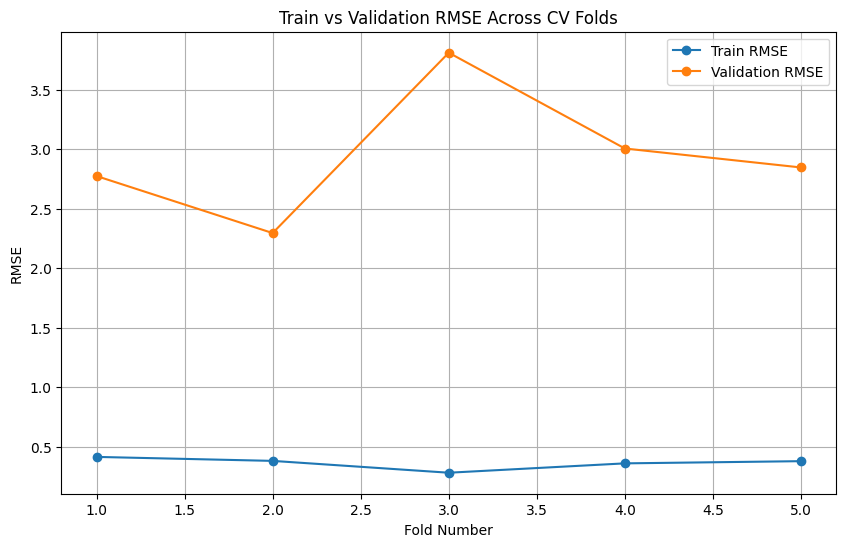

In [15]:
# Extracting train and test RMSE scores
# Negative because sklearn returns the negative RMSE
train_rmse_scores = -scores['train_rmse']
test_rmse_scores = -scores['test_rmse']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_rmse_scores) + 1),
         train_rmse_scores, 'o-', label='Train RMSE')
plt.plot(range(1, len(test_rmse_scores) + 1),
         test_rmse_scores, 'o-', label='Validation RMSE')

plt.title('Train vs Validation RMSE Across CV Folds')
plt.xlabel('Fold Number')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

### Feature Importance

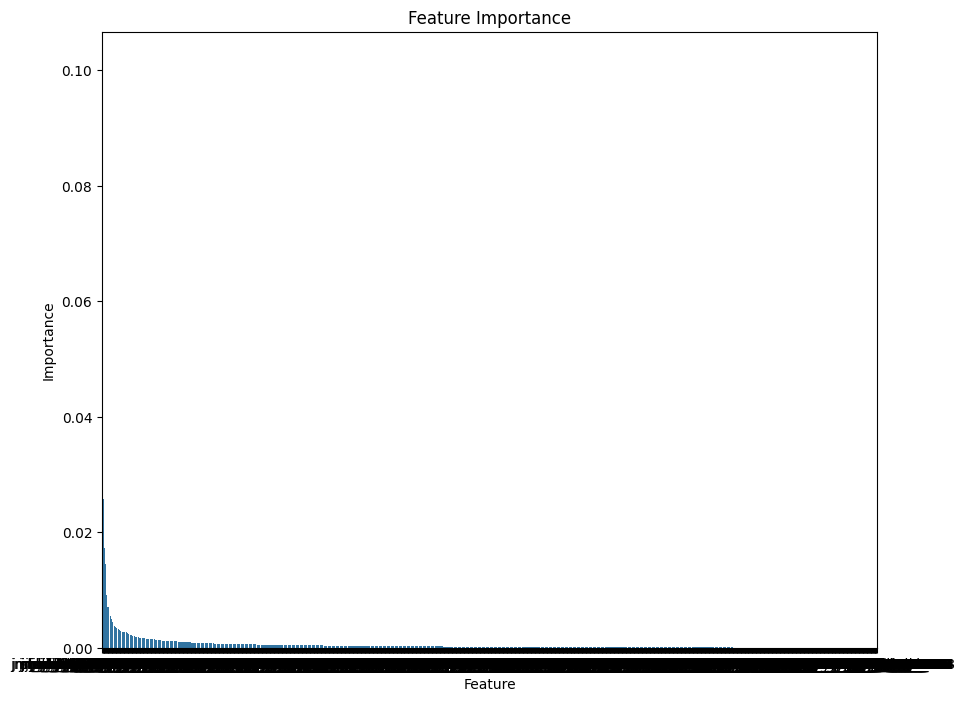

In [16]:
# Get feature importance
importance = xgb_cv_model.feature_importances_

# Create a DataFrame to display the importance along with feature names
importance_df = pd.DataFrame({
    'Feature': columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Feature', y='Importance', data=importance_df)
plt.title('Feature Importance')
plt.show()

### Residual Analysis

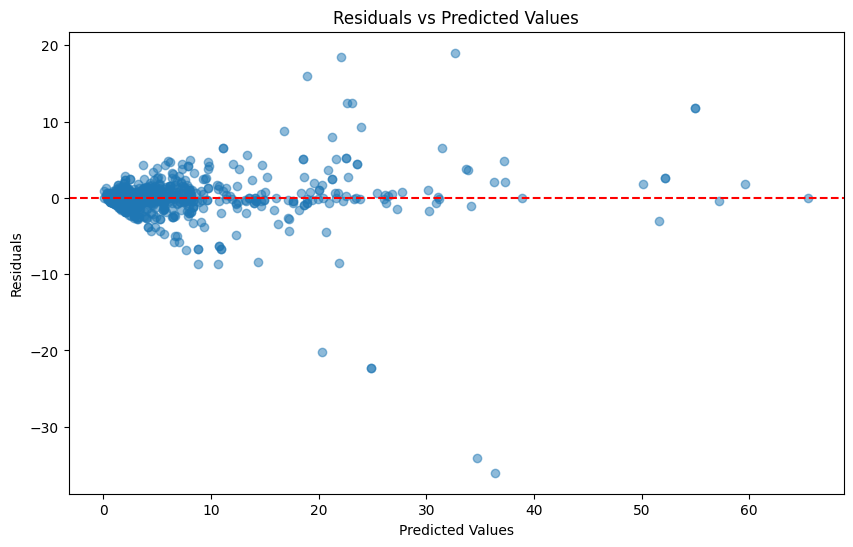

In [17]:
# Calculate residuals
residuals = y_test - y_pred

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

### Learning Curve Analysis

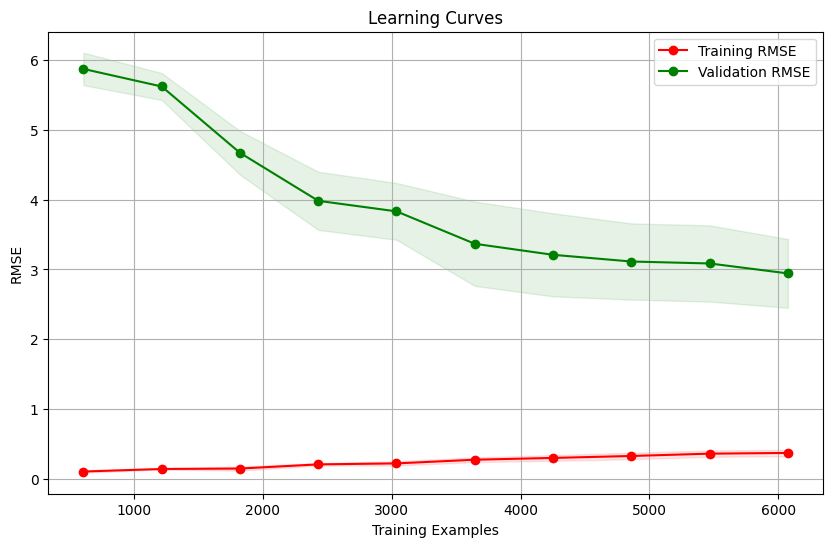

In [18]:
# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    XGBRegressor(learning_rate=0.05, max_depth=8,
                 subsample=0.8, colsample_bytree=0.5, min_child_weight=3, n_estimators=300),
    X_train_new, y_train_new, groups=groups, cv=gkf, scoring='neg_root_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std for plotting
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotting learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-',
         color="r", label="Training RMSE")
plt.plot(train_sizes, test_scores_mean, 'o-',
         color="g", label="Validation RMSE")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.title('Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('RMSE')
plt.legend(loc="best")
plt.grid(True)
plt.show()

### SHAP interpretation

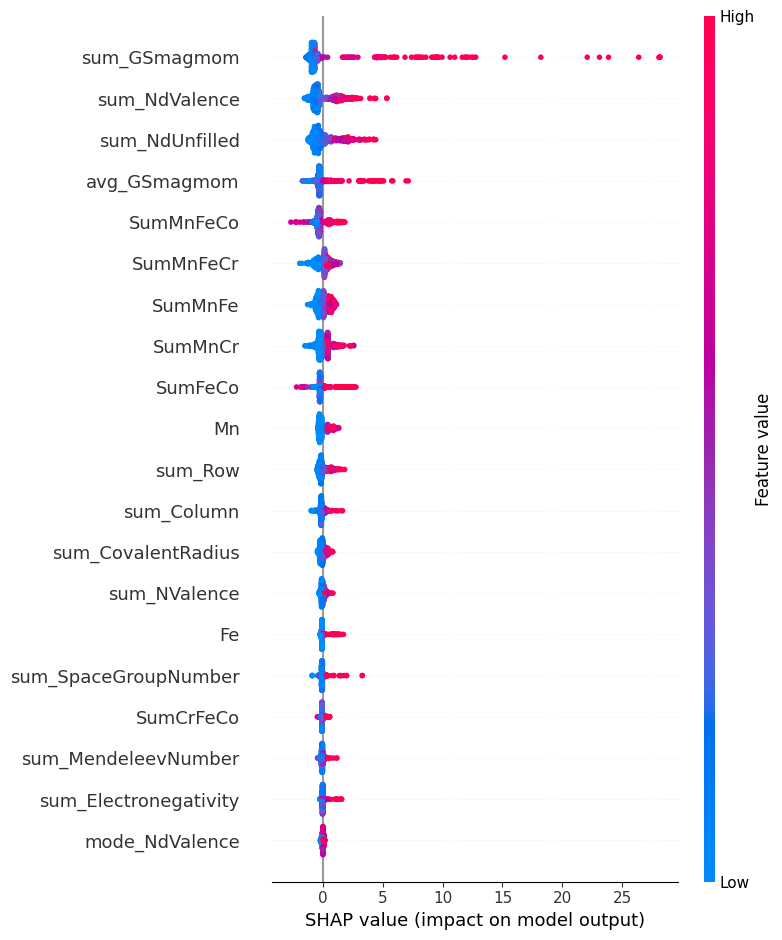

In [19]:
# Initialize the explainer
explainer = shap.TreeExplainer(xgb_cv_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Plotting summary plot
shap.summary_plot(shap_values, X_test, feature_names=columns)

In [32]:
xgb_explainer = shap.TreeExplainer(xgb_cv_model, X_train_new)
data_dmatrix = xgb.DMatrix(data=X_train_new, label=y_train_new)
y_pred = xgb_cv_model.predict(X_train_new)
shap_explainer_values = xgb_explainer(X_train_new, y_train_new)

 99%|===================| 7525/7594 [01:47<00:00]        

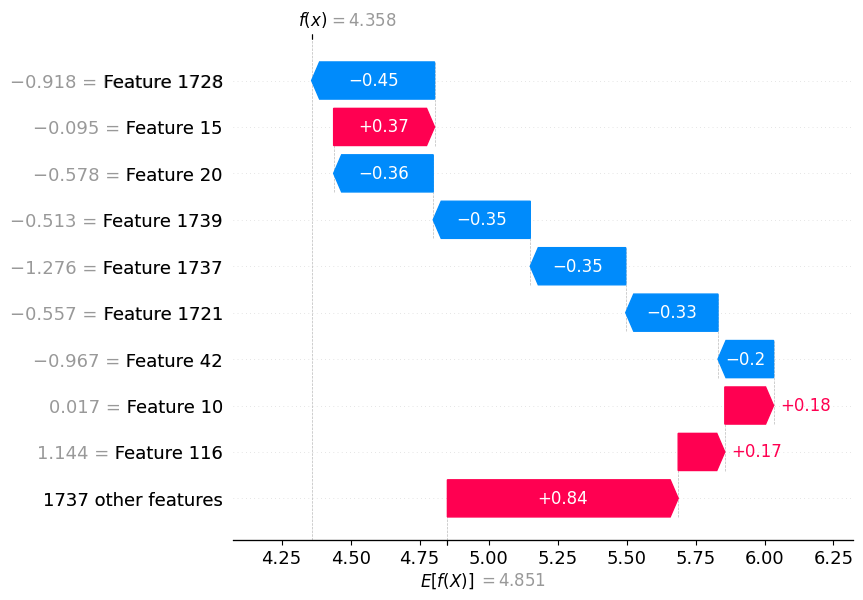

In [36]:
shap.waterfall_plot(shap_explainer_values[0])

In [ ]:
best_tree = xgb_model_reg.best_iteration
xgb_shadow_reg = ShadowXGBDTree(xgb_model_reg, best_tree, housing.data, housing.target,
                                housing.feature_names, housing.target_names)
trees.dtreeviz(xgb_shadow_reg)

## Regularized Model

### Training

In [20]:
xgb.set_config(verbosity=1)

xgb_cv_model_reg = XGBRegressor(learning_rate=0.1, max_depth=6,
                            subsample=0.8, colsample_bytree=1.0,
                            min_child_weight=5, reg_alpha=0.1, reg_lambda=0.1)

scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}

ti = time()

scores_reg = cross_validate(xgb_cv_model_reg, X_train_new, y_train_new, groups=groups, verbose=0, scoring=scoring, cv=gkf, return_train_score=True, error_score='raise')

xgb_cv_model_reg.fit(X_train_new, y_train_new, verbose=True)

dt = time() - ti

print(f'Finished fitting model, total time: {dt:0.2f} s')

print(scores_reg.keys())

Finished fitting model, total time: 33.18 s
dict_keys(['fit_time', 'score_time', 'test_r2', 'train_r2', 'test_rmse', 'train_rmse'])


### Evaluation

In [21]:
# Print cross-validation scores
print("Cross-validation R-squared scores:", scores_reg['test_r2'])
print("Mean R-squared score:", scores_reg['test_r2'].mean())

print("Cross-validation RMSE scores:", -scores_reg['test_rmse'])
print("Mean RMSE score:", -scores_reg['test_rmse'].mean())

Cross-validation R-squared scores: [0.89895689 0.91669343 0.84173689 0.90047934 0.90258743]
Mean R-squared score: 0.892090797817701
Cross-validation RMSE scores: [2.97614702 2.45162407 3.98256818 3.01849857 2.93142946]
Mean RMSE score: 3.072053460638245


In [22]:
y_pred_reg = xgb_cv_model_reg.predict(X_test)

# Calculate R-squared
r2_reg = r2_score(y_test, y_pred_reg)
print(f"R-squared: {r2_reg:.4f}")

# Calculate RMSE
rmse_reg = mean_squared_error(y_test, y_pred_reg, squared=False)
print(f"Root Mean Squared Error: {rmse_reg:.4f}")

R-squared: 0.8636
Root Mean Squared Error: 3.3699


/Users/andrew/Desktop/School/Research/ChemML/env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


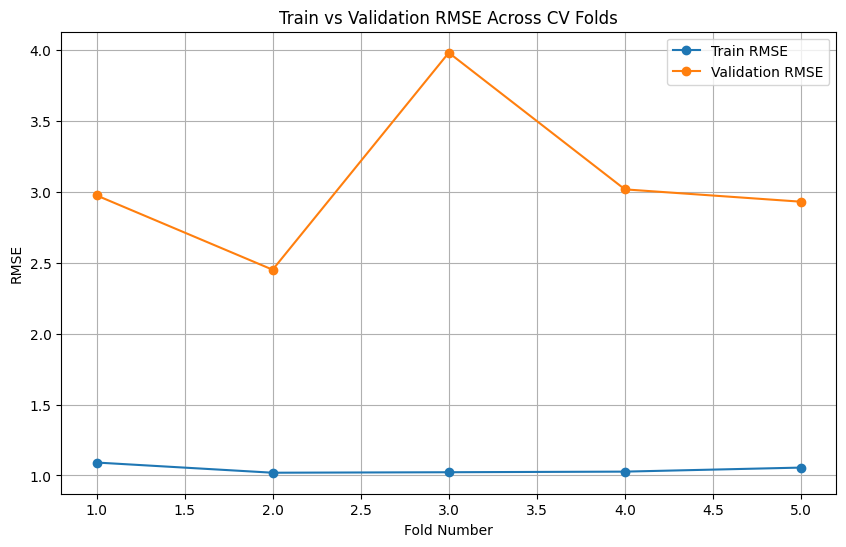

In [23]:
# Extracting train and test RMSE scores
# Negative because sklearn returns the negative RMSE
train_rmse_scores_reg = -scores_reg['train_rmse']
test_rmse_scores_reg = -scores_reg['test_rmse']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_rmse_scores_reg) + 1),
         train_rmse_scores_reg, 'o-', label='Train RMSE')
plt.plot(range(1, len(test_rmse_scores_reg) + 1),
         test_rmse_scores_reg, 'o-', label='Validation RMSE')

plt.title('Train vs Validation RMSE Across CV Folds')
plt.xlabel('Fold Number')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

### Feature Importance

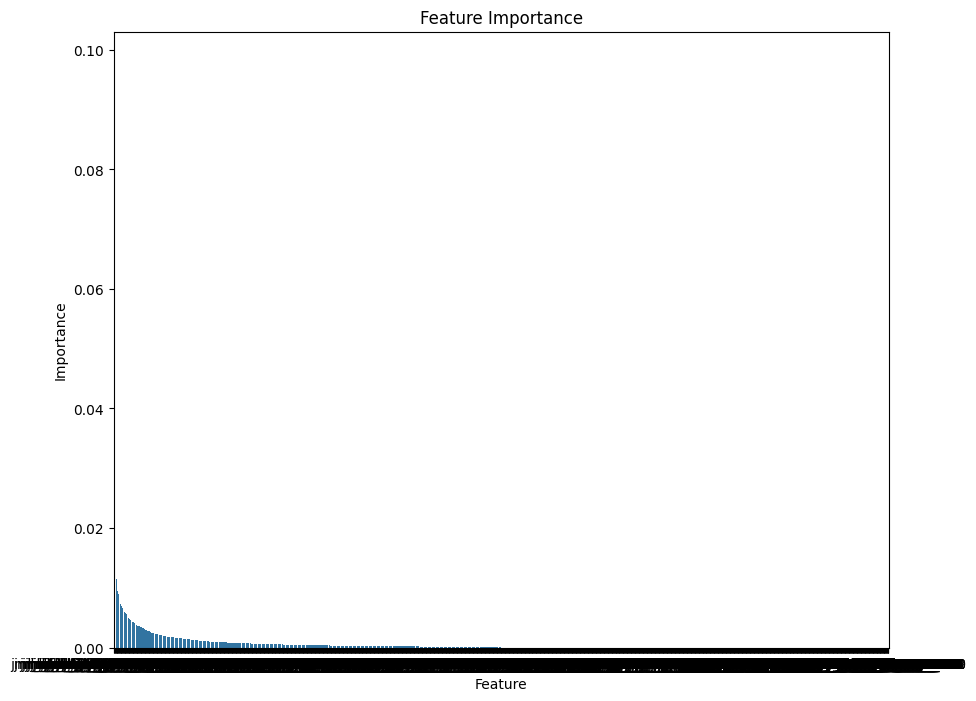

In [24]:
# Get feature importance
importance_reg = xgb_cv_model_reg.feature_importances_

# Create a DataFrame to display the importance along with feature names
importance_df_reg = pd.DataFrame({
    'Feature': columns,
    'Importance': importance_reg
}).sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Feature', y='Importance', data=importance_df_reg)
plt.title('Feature Importance')
plt.show()

### Residual Analysis

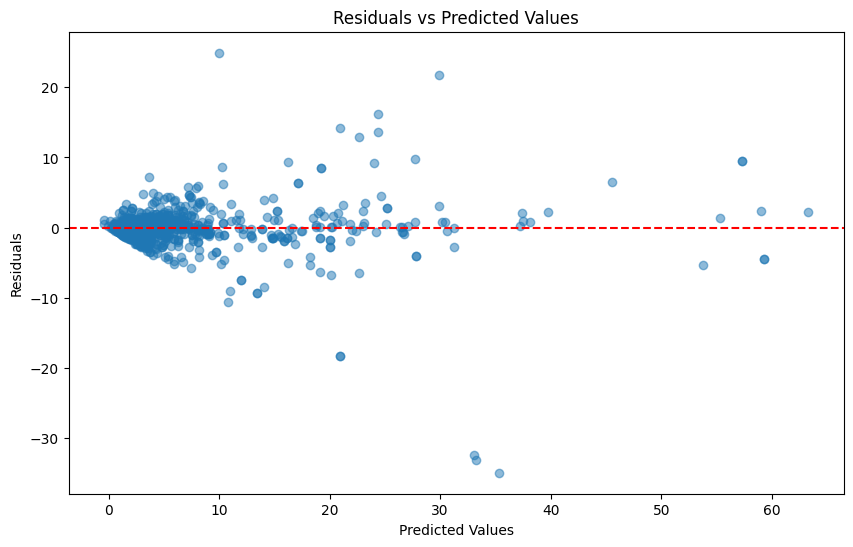

In [25]:
# Calculate residuals
residuals_reg = y_test - y_pred_reg

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_reg, residuals_reg, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

### Learning Curve Analysis

/Users/andrew/Desktop/School/Research/ChemML/env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


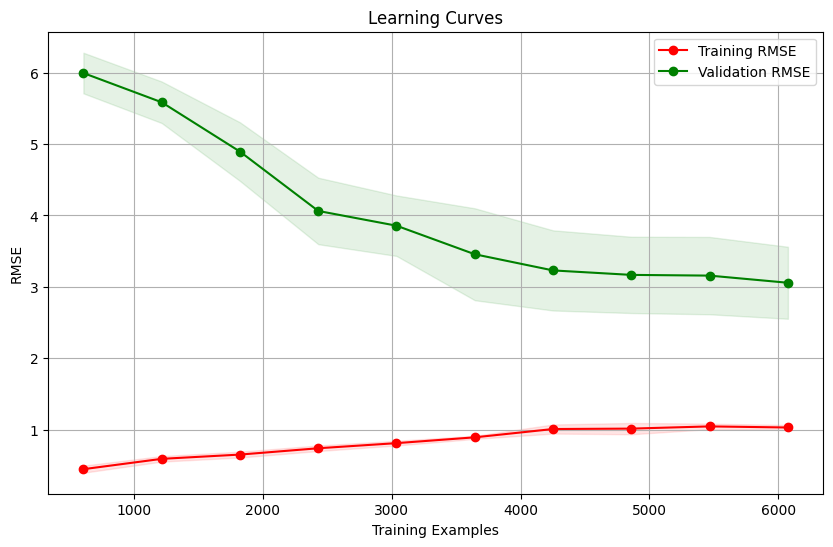

In [26]:
# Generate learning curve data
train_sizes_reg, train_scores_reg, test_scores_reg = learning_curve(
    XGBRegressor(learning_rate=0.1, max_depth=6, subsample=0.8,
                 colsample_bytree=1.0, min_child_weight=5, reg_alpha=0.1, reg_lambda=0.1),
    X_train_new, y_train_new, groups=groups, cv=gkf, scoring='neg_root_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std for plotting
train_scores_mean_reg = -np.mean(train_scores_reg, axis=1)
train_scores_std_reg = np.std(train_scores_reg, axis=1)
test_scores_mean_reg = -np.mean(test_scores_reg, axis=1)
test_scores_std_reg = np.std(test_scores_reg, axis=1)

# Plotting learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_reg, train_scores_mean_reg, 'o-',
         color="r", label="Training RMSE")
plt.plot(train_sizes_reg, test_scores_mean_reg, 'o-',
         color="g", label="Validation RMSE")

plt.fill_between(train_sizes_reg, train_scores_mean_reg - train_scores_std_reg,
                 train_scores_mean_reg + train_scores_std_reg, alpha=0.1, color="r")
plt.fill_between(train_sizes_reg, test_scores_mean_reg - test_scores_std_reg,
                 test_scores_mean_reg + test_scores_std_reg, alpha=0.1, color="g")

plt.title('Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('RMSE')
plt.legend(loc="best")
plt.grid(True)
plt.show()

### SHAP interpretation

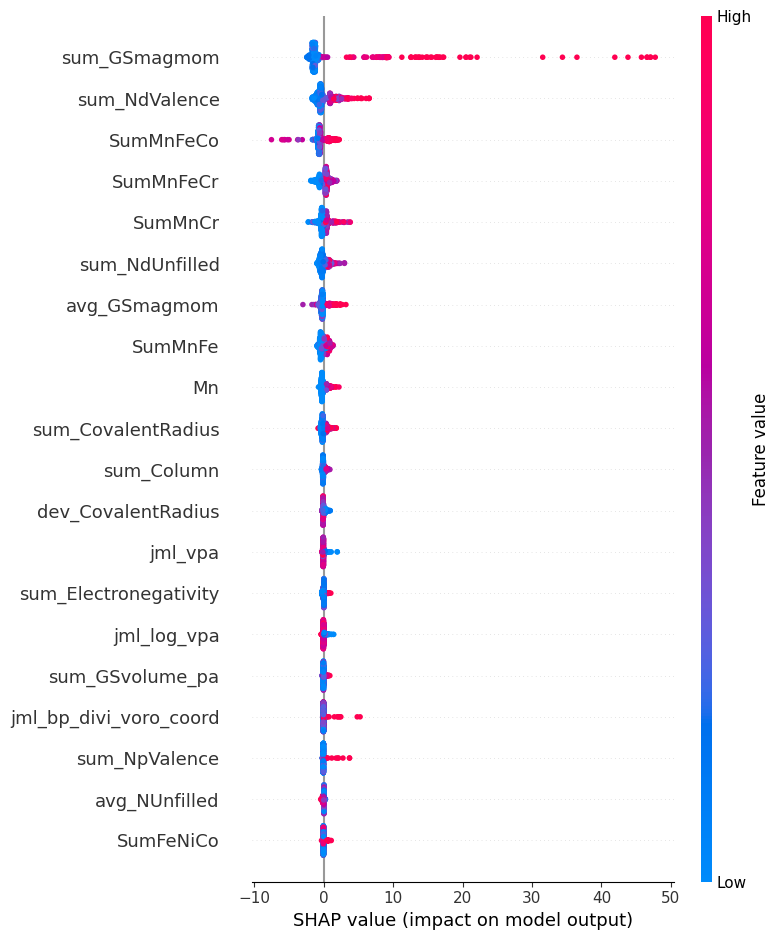

In [ ]:
# Initialize the explainer
explainer_reg = shap.TreeExplainer(xgb_cv_model_reg)

# Calculate SHAP values
shap_values_reg = explainer_reg.shap_values(X_test)

# Plotting summary plot
shap.summary_plot(shap_values_reg, X_test, feature_names=columns)

## Information

### Evaluation Explanations

Visualization of Losses: Helps to see how well the model is learning.

Feature Importance: Helps to understand which features are contributing the most to predictions.

Residual Analysis: Helps to analyze prediction errors.

Learning Curve: Helps to diagnose underfitting or overfitting.

Hyperparameter Tuning: Helps in finding the optimal set of hyperparameters.

SHAP Values: Provides model interpretability.

## Hyperparameter Tuning

### No Regularization

In [28]:
# Define the parameter grid
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 6, 8, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.8, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'n_estimators': [100, 300, 500, 1000]
}

# RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(xgb_cv_model, param_distributions=param_dist,
                                   scoring='neg_root_mean_squared_error',
                                   n_iter=50, cv=5, verbose=1, random_state=42, n_jobs=-1)

# Fit model
random_search.fit(X_train_new, y_train_new)

# Print best parameters and score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best RMSE: {-random_search.best_score_}")

# Output
# Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
# Best RMSE: 3.1402698241933984

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/andrew/Desktop/School/Research/ChemML/env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

### Regularization

In [ ]:
# Define the parameter grid
param_dist_reg = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 6, 8, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.8, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'n_estimators': [100, 300, 500, 1000],
    'reg_alpha': [0, 0.01, 0.05, 0.1, 0.2],
    'reg_lambda': [0, 0.01, 0.05, 0.1, 0.2],
}

# RandomizedSearchCV with 5-fold cross-validation
random_search_reg = RandomizedSearchCV(xgb_cv_model_reg, param_distributions=param_dist_reg,scoring='neg_root_mean_squared_error',n_iter=50, cv=5, verbose=1, random_state=42, n_jobs=-1)

# Fit model
random_search_reg.fit(X_train_new, y_train_new)

# Print best parameters and score
print(f"Best Parameters: {random_search_reg.best_params_}")
print(f"Best RMSE: {-random_search_reg.best_score_}")

# Output
#{'subsample': 0.6, 'reg_lambda': 0.05, 'reg_alpha': 0.05, 'n_estimators': 500,'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.8}

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/andrew/Desktop/School/Research/ChemML/env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'subsample': 0.6, 'reg_lambda': 0.05, 'reg_alpha': 0.05, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best RMSE: 3.1480333359440555
